# 训练

In [ ]:
# # 训练
# ! setsid python 3rdparty/mmdetection/tools/train.py cfg/yolov3_lard.py > train_yolov3.log 2>&1 &

# 优化

In [44]:
# 优化anchor
path_anchor = 'runs/yolov3'

# 原始anchor
# [(116, 90), (156, 198), (373, 326)],
# [(30, 61), (62, 45), (59, 119)],
# [(10, 13), (16, 30), (33, 23)]

! python mmdetection/tools/analysis_tools/optimize_anchors.py \
    cfg/yolov3_lard.py \
    --device cuda:0 \
    --input-shape 640 640 \
    --algorithm k-means \
    --output-dir {path_anchor}


loading annotations into memory...
Done (t=0.07s)
creating index...
index created!
10/31 21:22:27 - mmengine - INFO - Collecting bboxes from annotation...
[>>>>>>>>>>>>>>>>>>>>>>>] 11546/11546, 43480.2 task/s, elapsed: 0s, ETA:     0s

10/31 21:22:28 - mmengine - INFO - Collected 11545 bboxes.
10/31 21:22:28 - mmengine - INFO - Start cluster 9 YOLO anchors with K-means...
[>>>>                        ] 148/1000, 705.1 task/s, elapsed: 0s, ETA:     1s10/31 21:22:30 - mmengine - INFO - K-means process has converged at iter 148.


10/31 21:22:30 - mmengine - INFO - Anchor cluster finish. Average IOU: 0.7219271659851074
10/31 21:22:30 - mmengine - INFO - Anchor optimize result:[[10, 14], [19, 19], [26, 31], [42, 22], [46, 41], [75, 52], [120, 76], [198, 113], [366, 188]]
10/31 21:22:30 - mmengine - INFO - Result saved in runs/yolov3/anchor_optimize_result.json


In [45]:
import json

output = []
with open(path_anchor+"/anchor_optimize_result.json", 'r') as f:
    anchors = json.load(f)
    for anchor in anchors:
        output.append(tuple(anchor))
print(f"原始输出: {anchors}")

print("可复制格式: ")
print(f"{output[0+6:3+6]},")
print(f"{output[0+3:3+3]},")
print(output[0:3])

# 优化后
[(120, 76), (198, 113), (366, 188)],
[(42, 22), (46, 41), (75, 52)],
[(10, 14), (19, 19), (26, 31)]

原始输出: [[10, 14], [19, 19], [26, 31], [42, 22], [46, 41], [75, 52], [120, 76], [198, 113], [366, 188]]
可复制格式: 
[(120, 76), (198, 113), (366, 188)],
[(42, 22), (46, 41), (75, 52)],
[(10, 14), (19, 19), (26, 31)]


# 日志分析

['lr', 'data_time', 'grad_norm', 'loss', 'loss_cls', 'loss_conf', 'loss_xy', 'loss_wh', 'time', 'iter', 'memory', 'step']
['coco/bbox_mAP', 'coco/bbox_mAP_50', 'coco/bbox_mAP_75', 'coco/bbox_mAP_s', 'coco/bbox_mAP_m', 'coco/bbox_mAP_l', 'data_time', 'time']
最大map: (20)0.658


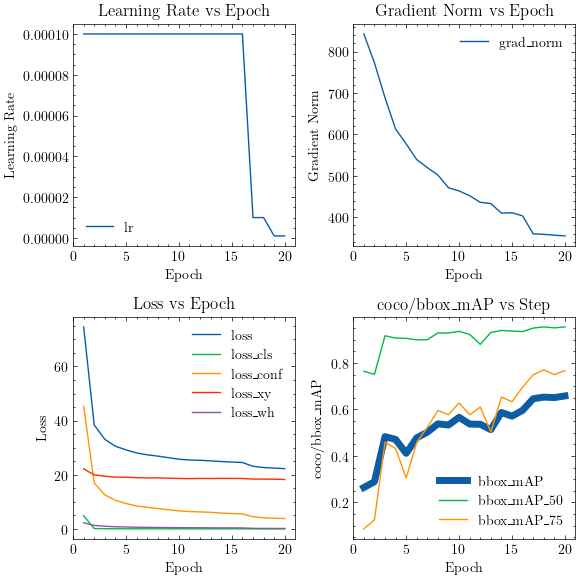

In [6]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import scienceplots

plt.style.use('science')


def read_json(file_path) -> tuple[pd.DataFrame, pd.DataFrame]:
    df_train = []
    df_val = []
    with open(file_path, 'r') as f:
        for line in f:
            record = json.loads(line.strip())
            if 'lr' in record:
                df_train.append(record)
            else:
                df_val.append(record)
    df_train = pd.DataFrame(df_train)
    df_val = pd.DataFrame(df_val)
    if len(df_train):
        df_train = df_train.groupby('epoch').mean()
        print(df_train.columns.to_list())
    if len(df_val):
        df_val = df_val.groupby('step').mean()
        print(df_val.columns.to_list())
        print(
            f"最大map: ({df_val['coco/bbox_mAP'].idxmax()}){df_val['coco/bbox_mAP'].max()}")
    return df_train, df_val


def plot_yolov3(df_train, df_val):
    fig, axs = plt.subplots(2, 2, figsize=(6, 6), dpi=100)
    axs = axs.flatten()
    if len(df_train):
        axs[0].plot(df_train.index, df_train['lr'], label='lr')
        axs[0].legend()
        axs[0].set_title('Learning Rate vs Epoch')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Learning Rate')
        axs[0].set_xlim(left=0)

        axs[1].plot(df_train.index, df_train['grad_norm'], label='grad_norm')
        axs[1].legend()
        axs[1].set_title('Gradient Norm vs Epoch')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Gradient Norm')
        axs[1].set_xlim(left=0)

        axs[2].plot(df_train.index, df_train['loss'], label='loss')
        axs[2].plot(df_train.index, df_train['loss_cls'], label='loss_cls')
        axs[2].plot(df_train.index, df_train['loss_conf'], label='loss_conf')
        axs[2].plot(df_train.index, df_train['loss_xy'], label='loss_xy')
        axs[2].plot(df_train.index, df_train['loss_wh'], label='loss_wh')
        axs[2].legend()
        axs[2].set_title('Loss vs Epoch')
        axs[2].set_xlabel('Epoch')
        axs[2].set_ylabel('Loss')
        axs[2].set_xlim(left=0)

    if len(df_val):
        axs[3].plot(
            df_val.index,
            df_val['coco/bbox_mAP'],
            label='bbox_mAP',
            linewidth=5)
        axs[3].plot(
            df_val.index,
            df_val['coco/bbox_mAP_50'],
            label='bbox_mAP_50')
        axs[3].plot(
            df_val.index,
            df_val['coco/bbox_mAP_75'],
            label='bbox_mAP_75')
        axs[3].legend()
        axs[3].set_title('coco/bbox_mAP vs Step')
        axs[3].set_xlabel('Epoch')
        axs[3].set_ylabel('coco/bbox_mAP')
        axs[3].set_xlim(left=0)
    plt.tight_layout()
    plt.show()


# 读取json文件
exp_id = '20231020_012418'
json_path = f'runs/yolov3/{exp_id}/vis_data/scalars.json'
df_train, df_val = read_json(json_path)

# 绘图
plot_yolov3(df_train, df_val)

# 测试

In [2]:
model_name='yolov3'
best_model_path=f"runs/{model_name}/best_coco_bbox_mAP_epoch_20.pth"
cfg_path=f'cfg/{model_name}_lard.py'

# 测试-synth
! python mmdetection/tools/test.py \
    {cfg_path} \
    {best_model_path} \
    --cfg-options \
    test_evaluator.outfile_prefix=runs/{model_name}/test/coco_detection/prediction_test_synth \
    work_dir=runs/{model_name}/test/

# 测试-nominal
! python mmdetection/tools/test.py \
    {cfg_path} \
    {best_model_path} \
    --cfg-options \
    test_dataloader.dataset.ann_file=annotations/instances_test_real_nominal.json \
    test_dataloader.dataset.data_prefix.img=YoloFormat/test_real_nominal/images/ \
    test_evaluator.ann_file=datasets/lard/annotations/instances_test_real_nominal.json \
    test_evaluator.outfile_prefix=runs/{model_name}/test/coco_detection/prediction_test_real_nominal \
    work_dir=runs/{model_name}/test/

# 测试-edge
! python mmdetection/tools/test.py \
    {cfg_path} \
    {best_model_path} \
    --cfg-options \
    test_dataloader.dataset.ann_file=annotations/instances_test_real_edge.json \
    test_dataloader.dataset.data_prefix.img=YoloFormat/test_real_edge/images/ \
    test_evaluator.ann_file=datasets/lard/annotations/instances_test_real_edge.json \
    test_evaluator.outfile_prefix=runs/{model_name}/test/coco_detection/prediction_test_real_edge \
    work_dir=runs/{model_name}/test/


10/20 16:23:48 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
    CUDA available: True
    numpy_random_seed: 823829483
    GPU 0: NVIDIA GeForce GTX 1070
    CUDA_HOME: /usr/local/cuda-11.1
    NVCC: Cuda compilation tools, release 11.1, V11.1.74
    GCC: gcc (Ubuntu 9.4.0-1ubuntu1~20.04.2) 9.4.0
    PyTorch: 1.10.2+cu111
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,

# 评估

In [7]:
from pycocotools.cocoeval import COCOeval
from pycocotools.coco import COCO

# 保存评价结果
coco_evals = {}
model_name = 'yolov3'

# 在各测试集进行推理
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    print(f'正在评价: {data_type}')
    annotation_file = f'datasets/lard/annotations/instances_{data_type}.json'
    prediction_file = f'runs/{model_name}/test/coco_detection/prediction_{data_type}.bbox.json'

    coco_true = COCO(annotation_file=annotation_file)
    coco_pre = coco_true.loadRes(resFile=prediction_file)

    coco_evaluator = COCOeval(
        cocoGt=coco_true,
        cocoDt=coco_pre,
        iouType="bbox")
    coco_evaluator.evaluate()
    coco_evaluator.accumulate()
    coco_evaluator.summarize()

    coco_evals[data_type] = coco_evaluator

正在评价: test_synth
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.658
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.955
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.767
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.568
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.701
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.720
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.721
 Average Recall     (AR) @[ IoU=0.50:0.95 | are

In [9]:
import pandas as pd

metrics = [
    "AP (IoU=0.50:0.95, area=all, maxDets=100)",
    "AP (IoU=0.50, area=all, maxDets=100)",
    "AP (IoU=0.75, area=all, maxDets=100)",
    "AP (IoU=0.50:0.95, area=small, maxDets=100)",
    "AP (IoU=0.50:0.95, area=medium, maxDets=100)",
    "AP (IoU=0.50:0.95, area=large, maxDets=100)",
    "AR (IoU=0.50:0.95, area=all, maxDets=1)",
    "AR (IoU=0.50:0.95, area=all, maxDets=10)",
    "AR (IoU=0.50:0.95, area=all, maxDets=100)",
    "AR (IoU=0.50:0.95, area=small, maxDets=100)",
    "AR (IoU=0.50:0.95, area=medium, maxDets=100)",
    "AR (IoU=0.50:0.95, area=large, maxDets=100)"
]

all_metrics = {}
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:
    cocoEval = coco_evals[data_type]
    all_metrics[data_type] = cocoEval.stats

all_metrics = pd.DataFrame(all_metrics, index=metrics)
display(all_metrics.round(3))

,test_synth,test_real_nominal,test_real_edge
"AP (IoU=0.50:0.95, area=all, maxDets=100)",0.658,0.467,0.194
"AP (IoU=0.50, area=all, maxDets=100)",0.955,0.762,0.370
"AP (IoU=0.75, area=all, maxDets=100)",0.767,0.507,0.191
"AP (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.148,0.141
"AP (IoU=0.50:0.95, area=medium, maxDets=100)",0.568,0.347,0.126
"AP (IoU=0.50:0.95, area=large, maxDets=100)",0.701,0.658,0.255
"AR (IoU=0.50:0.95, area=all, maxDets=1)",0.720,0.524,0.239
"AR (IoU=0.50:0.95, area=all, maxDets=10)",0.721,0.538,0.258
"AR (IoU=0.50:0.95, area=all, maxDets=100)",0.721,0.538,0.258
"AR (IoU=0.50:0.95, area=small, maxDets=100)",-1.000,0.210,0.160


# 推理

In [5]:
import glob
from tqdm import tqdm
from PIL import Image
from collections import Counter

# 参数定义
model_name = 'yolov3'
best_epoch = 20
best_model_path = f'runs/{model_name}/best_coco_bbox_mAP_epoch_{best_epoch}.pth'
cfg_path = f'cfg/{model_name}_lard.py'

# 在各测试集进行统计
for data_type in ['test_synth', 'test_real_nominal', 'test_real_edge']:

    # 数据列表
    path = f'datasets/lard/YoloFormat/{data_type}/images/'
    image_paths = glob.glob(f"{path}*")

    # 尺寸统计
    image_dimensions = []
    for image_path in tqdm(image_paths, ncols=100, desc="统计"):
        img = Image.open(image_path)
        image_dimensions.append(img.size)
    dimensions_counter = Counter(image_dimensions)
    print(f"{data_type}: {dimensions_counter}")

统计: 100%|██████████████████████████████████████████████████| 2212/2212 [00:00<00:00, 20993.54it/s]


test_synth: Counter({(2448, 2048): 2212})


统计: 100%|██████████████████████████████████████████████████| 1500/1500 [00:00<00:00, 23339.20it/s]


test_real_nominal: Counter({(3840, 2160): 750, (1920, 1080): 628, (1280, 720): 96, (1902, 1080): 19, (1918, 1080): 7})


统计: 100%|████████████████████████████████████████████████████| 311/311 [00:00<00:00, 21407.24it/s]

test_real_edge: Counter({(3840, 2160): 178, (1920, 1080): 109, (1280, 720): 24})


# 测速

In [3]:
# 参数定义
model_name = 'yolov3'
best_epoch = 20
best_model_path = f'runs/{model_name}/best_coco_bbox_mAP_epoch_{best_epoch}.pth'
cfg_path = f'cfg/{model_name}_lard.py'

# 开始测试
! python mmdetection/tools/analysis_tools/benchmark.py \
    {cfg_path} \
    --checkpoint {best_model_path} \
    --task inference \
    --repeat-num 3 \
    --log-interval 100 \
    --num-warmup 100 \
    --dataset-type test

# TODO 在real上进行测速

10/21 22:02:22 - mmengine - INFO - before build: 
10/21 22:02:22 - mmengine - INFO - (GB) mem_used: 4.98 | uss: 0.40 | pss: 0.76 | total_proc: 1
Loads checkpoint by local backend from path: runs/yolov3/best_coco_bbox_mAP_epoch_20.pth
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
10/21 22:02:24 - mmengine - INFO - after build: 
10/21 22:02:24 - mmengine - INFO - (GB) mem_used: 6.95 | uss: 2.92 | pss: 3.29 | total_proc: 1
10/21 22:02:33 - mmengine - INFO - ==================================
10/21 22:02:42 - mmengine - INFO - ==================================
10/21 22:02:42 - mmengine - INFO - Done image [200/2000], fps: 21.0 img/s, times per image: 47.6 ms/img, cuda memory: 358 MB
10/21 22:02:42 - mmengine - INFO - (GB) mem_used: 6.98 | uss: 2.98 | pss: 3.35 | total_proc: 1
10/21 22:02:50 - mmengine - INFO - ==================================
10/21 22:02:51 - mmengine - INFO - Done image [300/2000], fps: 21.1 img/s, times per image: 47.5 ms/img, cuda